In [93]:
import pandas as pd
import numpy as np
from pandas import CategoricalDtype

import seaborn as sns
from matplotlib import pyplot as plt

Data dictionary

sex: 1, Male | 2, Female | 3, Other   

gender: 1, Man | 2, Woman | 3, Non-Binary | 4, Other  

edu_level: 1, 1-8 Less than high school | 2, 9-11 Some high school | 3, 12 High school degree | 4, 13-15 Some college | 5, 16 Bachelor's degree in college (4-year) | 6, 17-25 Graduate School 

income: 1, Less than $10,000 | 2, $10,000 to $19,999 | 3, $20,000 to $29,999 | 4, $30,000 to $39,999 | 5, $40,000 to $49,999 | 6, $50,000 to $59,999 | 7, $60,000 to $69,999 | 8, $70,000 to $79,999 | 9, $80,000 to $89,999 | 10, $90,000 to $99,999 | 11, $100,000 to $149,999 | 12, $150,000 or more      

race: 1, American Indian or Alaska Native | 2, Asian | 3, Black or African American | 4, Latino or Hispanic | 5, Multiracial | 6, Native Hawaiian or Pacific Islander | 7, White | 8, Other   

ladder_us: 1~10 scale




Note:  

6 missing BDI and PVSS scores  

Baseline UG data files: 245 (complete submission & passed attention check), RT screened  

UG 236 > no missing psychiatric scores > ANALYSIS N (same initial subset for RL 236)  

Baseline RL data file raw: 251, match with complete subject from UG 235 (1 missing), then performance check and RT screen >>> 220 

# Data loading (baseline)

In [94]:
# behavior data
baseline_ug = pd.read_csv('./data/raw/LEAP_baseline_ug_raw.csv') # completed submission and attention checked
baseline_rl = pd.read_csv('./data/raw/LEAP_baseline_rl_raw.csv')

# psychiatric & demographics data
demo_raw = pd.read_csv(f'./data/raw/LEAP_baseline_survey.csv')
demo_raw = demo_raw.rename(columns={"prolific_pid":"participant"})

# month1 survey
month1_survey = pd.read_csv('./data/raw/LEAP_month1_survey.csv')
month1_survey = month1_survey.rename(columns={"prolific_pid":"participant"})

## double check N = 235 demographics analysis 
ID = 610cd5f2b38b2d1bffe55477          
subject reported Sex as other, hence excluded from regression analysis due to sex variable recording       


# Psychiatric survey check & groupping

In [95]:
# check for missing clinical data (244 for BDI, 253 for PVSS)
bdi = demo_raw[['participant', 'bdi_total']]
pvss = demo_raw[['participant', 'pvss_total']]

ids_nomising = bdi.dropna(subset=['bdi_total'])
ids_nomising = ids_nomising.reset_index(drop=True)
all_ids = ids_nomising['participant'].unique() 

print('complete BDI data n =', len(all_ids))

complete BDI data n = 244


In [96]:
pvss_match = pvss[pvss['participant'].isin(all_ids)]
pvss_med = pvss_match['pvss_total'].median()
print('PVSS sample median =', pvss_med)

PVSS sample median = 6.76190476190476


In [97]:
# BDI-II & PVSS group by cutoff criteria 
def grouping(bdi_total, pvss_score):
    if bdi_total > 13 and pvss_score < pvss_med:
        group = 'Both'
    elif bdi_total > 13 and pvss_score >= pvss_med:
        group = 'Depression'
    elif pvss_score < pvss_med and bdi_total <= 13:
        group = 'Anhedonia'
    else:
        group = 'Healthy'
    return group

In [98]:
# additional psych data
sas = demo_raw[['participant','sas_total', 'bai_total']]
sas = sas.rename(columns={"sas_total":"apathy_score", 'bai_total':"anxiety_score"})

# merge all psych data based on participant id
psych_data = pd.merge(bdi, pvss, on='participant')[['participant', 'bdi_total', 'pvss_total']]
psych_data = pd.merge(psych_data, sas, on='participant')
psych_data['group'] = psych_data.apply(lambda x: grouping(x['bdi_total'], x['pvss_total']), axis=1)
# Add group label and simple contrast coding for depression and anhedonia 
psych_data['depression'] = psych_data['group'].apply(lambda x: 1 if x in ['Depression', 'Both'] else 0)
psych_data['anhedonia'] = psych_data['group'].apply(lambda x: 1 if x in ['Anhedonia', 'Both'] else 0)

psych_data = psych_data[psych_data['participant'].isin(all_ids)]
psych_data

,participant,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia
0,5d1855f26be726001a39cf9b,3.0,3.285714,18,9,Anhedonia,0,1
1,6101d433c8a23b9b39e41009,35.0,4.000000,9,38,Both,1,1
2,60fcbc5369b93b4dc6c26e16,1.0,8.285714,5,11,Healthy,0,0
3,603595f7c81d8e6ceaa65476,28.0,5.476190,28,16,Both,1,1
4,56c3ee7411e094000dd4654d,25.0,5.190476,13,30,Both,1,1
...,...,...,...,...,...,...,...,...
248,63b6cee06aaa9fc9669b8cc2,2.0,7.619048,8,16,Healthy,0,0
249,62728f0c68b9ecf571a2dbd4,27.0,5.761905,19,4,Both,1,1
250,597fe89a1b41a20001749f57,1.0,7.285714,0,0,Healthy,0,0
251,606a3cf263a18869ac8ee0ed,12.0,7.428571,7,1,Healthy,0,0


# Demographics recoding

In [99]:
# load raw data set for demographics
demographics = demo_raw[demo_raw.columns[:33]]
# demographics = demographics.rename(columns={"prolific_pid":"participant"})
demographics = pd.merge(demographics, psych_data, on='participant') # join psych and demographics
print(demographics.columns)
# find proflicids id in demographics from baseline ids
demographics = demographics[demographics['participant'].isin(baseline_ug['participant'].unique())]

Index(['Unnamed: 0', 'record_id', 'participant', 'demographics_timestamp',
       'age', 'sex', 'gender', 'hit', 'race___1', 'race___2', 'race___3',
       'race___4', 'race___5', 'race___6', 'race___7', 'race___8',
       'race_other', 'edu_level', 'attention_3', 'marriage', 'handedness',
       'polit_party', 'polit_party_other', 'sm1', 'job', 'job_other',
       'occupation', 'income', 'ladder_us', 'religion', 'state', 'zip_code',
       'adjust', 'bdi_total', 'pvss_total', 'apathy_score', 'anxiety_score',
       'group', 'depression', 'anhedonia'],
      dtype='object')


In [100]:
demographics.head()

,Unnamed: 0,record_id,participant,demographics_timestamp,age,sex,gender,hit,race___1,race___2,...,state,zip_code,adjust,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia
5,6,18,61006614d4c56450afce3a6b,2023-02-03 17:56:38,30,2,2,1,0,0,...,44,786,0,6.0,5.952381,11,8,Anhedonia,0,1
6,7,19,5c935d881754ba001b25697a,2023-02-03 18:01:51,38,2,2,1,0,0,...,44,786,0,24.0,7.047619,20,16,Depression,1,0
7,8,20,6078163f1e585e4f71e3b879,2023-02-03 18:11:09,61,2,2,1,0,0,...,30,31,0,10.0,4.238095,11,23,Anhedonia,0,1
8,9,21,61533552778007d9dbe260f2,2023-02-03 18:15:43,40,1,1,1,0,0,...,19,703,0,3.0,6.904762,8,3,Healthy,0,0
9,10,22,5c0023fb2213be0001c2cdde,2023-02-03 18:17:34,32,2,2,1,0,0,...,44,793,0,8.0,6.761905,11,1,Healthy,0,0


In [101]:
# create dictionary to map race id to race
# 1, American Indian or Alaska Native | 2, Asian | 3, Black or African American | 4, Latino or Hispanic | 5, Multiracial | 6, Native Hawaiian or Pacific Islander | 7, White | 8, Other

race_dict = {'race___1': 'American Indian or Alaska Native', 'race___2': 'Asian', 'race___3': 'Black or African American', 'race___4': 'Latino or Hispanic', 'race___5': 'Multiracial', 'race___6': 'Native Hawaiian or Pacific Islander', 'race___7': 'White', 'race___8': 'Other'}
race = demographics[['participant', 'race___1', 'race___2', 'race___3', 'race___4', 'race___5', 'race___6', 'race___7', 'race___8']]
race.rename(columns=race_dict, inplace=True)

# reformat dataframe
race = pd.melt(race, id_vars=['participant'], var_name='race', value_name='Binary_Code')
race = race[race['Binary_Code'] == 1] # Filter out rows with Binary_Code == 1 / reported race
race = race.drop(columns=['Binary_Code']) # Drop the Binary_Code column

#recode for multiple selection to a single multiracial label
multi_race_ids = race[race['participant'].duplicated(keep=False)].groupby('participant').apply(lambda x: len(x['race']) > 1)
race.loc[race['participant'].isin(multi_race_ids[multi_race_ids].index), 'race'] = 'Multiracial'
race.drop_duplicates(subset=['participant'], keep='first', inplace=True) # Drop duplicate rows (keeping the first occurrence)

# Reset the index
race = race.reset_index(drop=True)
race = race.sort_values('race', ascending=True)
race.describe()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_16472\793578444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race.rename(columns=race_dict, inplace=True)


,participant,race
count,236,236
unique,236,7
top,5c55faafb571e7000119e576,White
freq,1,161


In [102]:
# clean data for income (earning up to a certain amount)
#  1, Less than $10,000 | 2, $10,000 to $19,999 | 3, $20,000 to $29,999 | 4, $30,000 to $39,999 | 5, $40,000 to $49,999 | 6, $50,000 to $59,999 | 7, $60,000 to $69,999 | 8, $70,000 to $79,999 | 9, $80,000 to $89,999 | 10, $90,000 to $99,999 | 11, $100,000 to $149,999 | 12, $150,000 or more

income_dict = {1: '< $10,000', 2: '$20,000', 3: '$30,000', 4: '$40,000', 5: '$50,000', 6: '$60,000', 7: '$70,000', 8: '$80,000', 9: '$90,000', 10: '$100,000', 11: '$150,000', 12: ' > $150,000'}
income_list = list(income_dict.values())

income = demographics[['participant', 'income']]
income = income.sort_values('income', ascending=False)
income['income'] = income['income'].map(income_dict)
income['income_order'] = income['income'].map({v: k for k, v in income_dict.items()})
income.head()

,participant,income,income_order
28,5f405adcda0ade19c87826bd,"> $150,000",12
128,6307bee7b345c1bf0fb2f362,"> $150,000",12
50,607357623fd10fe43a18787c,"> $150,000",12
206,5f6f738fef894f0dbf9839f8,"> $150,000",12
34,5aeb46c5ed102400010f26cb,"> $150,000",12


In [103]:
# screen for prior diagnosises
diag_df = demo_raw[['participant','adhd',"autism","bipolar","avpd","bpd","mdd","ed","gad","ocd","ld","panic","gambling","ptsd","scz","spd","sad","tourettes","sud","other_disorder"]]

nan_list = ['no', 'none', 'None', 'None.', 'na']
diag_df.loc[:, 'other_disorder'] = diag_df['other_disorder'].replace(nan_list, float('nan'))
diag_df.loc[:, 'other_disorder_b'] = diag_df['other_disorder'].notnull().astype(int)
diag_df = diag_df.drop('other_disorder', axis=1)

# sum across all columns except for 'prolific_pid'
diag_df['total_prior_diag'] = diag_df.iloc[:, 1:].sum(axis=1)
diag_df.loc[:, 'total_prior_diag'] += diag_df['other_disorder_b']
diag_df['md_anx_prior_diag'] = diag_df.eval('bipolar + mdd + gad + panic + ptsd + sad')
diag_df['non_md_prior_diag'] = diag_df.eval('adhd + autism + avpd + bpd + ed + ocd + ld + gambling + scz + spd + tourettes + sud + other_disorder_b')

no_prior_dia_n = diag_df['total_prior_diag'].value_counts()[0]
no_prior_md_n = diag_df['md_anx_prior_diag'].value_counts()[0]
print(f'Number of participants with no prior diagnosis: {no_prior_dia_n}')
print(f'Number of participants with no prior mood or anxiety diagnosis: {no_prior_md_n} \n\n\n')

diag_df.head()

Number of participants with no prior diagnosis: 145
Number of participants with no prior mood or anxiety diagnosis: 156 





C:\Users\fuq01\AppData\Local\Temp\ipykernel_16472\841566803.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_df.loc[:, 'other_disorder'] = diag_df['other_disorder'].replace(nan_list, float('nan'))
C:\Users\fuq01\AppData\Local\Temp\ipykernel_16472\841566803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_df.loc[:, 'other_disorder_b'] = diag_df['other_disorder'].notnull().astype(int)


,participant,adhd,autism,bipolar,avpd,bpd,mdd,ed,gad,ocd,...,ptsd,scz,spd,sad,tourettes,sud,other_disorder_b,total_prior_diag,md_anx_prior_diag,non_md_prior_diag
0,5d1855f26be726001a39cf9b,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,1
1,6101d433c8a23b9b39e41009,0,0,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,4,4,0
2,60fcbc5369b93b4dc6c26e16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,603595f7c81d8e6ceaa65476,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,2,2,0
4,56c3ee7411e094000dd4654d,1,0,0,0,0,1,1,1,0,...,1,0,0,1,0,0,0,6,4,2


In [104]:
# sex and gender mismatch check
demographics.loc[:, 'queer'] = 0  # Initialize all values to 0
non_binary_other = [3, 4]  # Additional gender values to consider as non-binary or other

# Set 'queer' to 1 where 'sex' and 'gender' don't match, or 'gender' is non-binary or other
demographics.loc[(demographics['sex'] != demographics['gender']) | demographics['gender'].isin(non_binary_other) | demographics['sex'].isin(non_binary_other), 'queer'] = 1
queer_n = demographics['queer'].value_counts()[1]
q_df = demographics[demographics['queer'] == 1]
print(f'Number of queer participants: {queer_n}')

Number of queer participants: 6


In [105]:
# select key demographics variables
demo_keys = demographics[['participant', 'age', 'sex', 'gender', 'edu_level', 'ladder_us', 'queer']]
demo_keys.head()

# merge demo_keys using prolific_pid
demo_keys = pd.merge(demo_keys, income, on='participant')
demo_keys = pd.merge(demo_keys, race, on='participant')
demo_keys = pd.merge(demo_keys, diag_df[['participant', 'total_prior_diag', 'md_anx_prior_diag', 'non_md_prior_diag']], on='participant')
demo_keys = pd.merge(demo_keys, psych_data, on='participant')

In [106]:
demo_keys = demo_keys[demo_keys['participant'].isin(baseline_ug['participant'].unique())]
print("N =", demo_keys['participant'].nunique())
demo_keys.head()

N = 236


,participant,age,sex,gender,edu_level,ladder_us,queer,income,income_order,race,total_prior_diag,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia
0,61006614d4c56450afce3a6b,30,2,2,6,5,0,"$90,000",9,Latino or Hispanic,0,0,0,6.0,5.952381,11,8,Anhedonia,0,1
1,5c935d881754ba001b25697a,38,2,2,5,5,0,"> $150,000",12,White,1,1,0,24.0,7.047619,20,16,Depression,1,0
2,6078163f1e585e4f71e3b879,61,2,2,4,4,0,"$100,000",10,White,0,0,0,10.0,4.238095,11,23,Anhedonia,0,1
3,61533552778007d9dbe260f2,40,1,1,4,4,0,"$70,000",7,White,0,0,0,3.0,6.904762,8,3,Healthy,0,0
4,5c0023fb2213be0001c2cdde,32,2,2,3,4,0,"$60,000",6,White,3,0,2,8.0,6.761905,11,1,Healthy,0,0


In [107]:
demo_keys.groupby(['group'])['participant'].count().reset_index()

,group,participant
0,Anhedonia,45
1,Both,71
2,Depression,29
3,Healthy,91


# Demographics by groups & summary

In [108]:
from scipy import stats
import statsmodels.stats.anova as anova

Demographics by group summary

In [109]:
# Mean age and standard deviation
age = demo_keys.groupby('group')['age'].mean().reset_index()
std = demo_keys.groupby('group')['age'].std().reset_index()
demo_group_df = pd.merge(age, std, on='group', suffixes=('_mean', '_std'))

# ANOVA for age across groups
anova_age = stats.f_oneway(*(demo_keys[demo_keys['group'] == group]['age'] for group in demo_keys['group'].unique()))
demo_group_df['anova_age_p_value'] = anova_age.pvalue

# Female sex count and percentage
sex = demo_keys.groupby('group')['sex'].value_counts(normalize=False).reset_index(name='female_count')
sex_percent = demo_keys.groupby('group')['sex'].value_counts(normalize=True).reset_index(name='female_percent')
sex_combined = pd.merge(sex, sex_percent, on=['group', 'sex'])
sex_combined = sex_combined[sex_combined['sex'] == 2].drop(columns='sex')
demo_group_df = pd.merge(demo_group_df, sex_combined, on='group')

# Woman gender count and percentage
gender = demo_keys.groupby('group')['gender'].value_counts(normalize=False).reset_index(name='woman_count')
gender_percent = demo_keys.groupby('group')['gender'].value_counts(normalize=True).reset_index(name='woman_percent')
gender_combined = pd.merge(gender, gender_percent, on=['group', 'gender'])
gender_combined = gender_combined[gender_combined['gender'] == 2].drop(columns='gender')
demo_group_df = pd.merge(demo_group_df, gender_combined, on='group')

# Each race count and percentage
race = demo_keys.groupby('group')['race'].value_counts(normalize=False).reset_index(name='race_count')
race_percent = demo_keys.groupby('group')['race'].value_counts(normalize=True).reset_index(name='race_percent')
race_combined = pd.merge(race, race_percent, on=['group', 'race'])
demo_group_df = pd.merge(demo_group_df, race_combined, on='group', how='left')

# Education median
edu = demo_keys.groupby(['group'])['edu_level'].agg(pd.Series.median).reset_index(name='edu_med')
demo_group_df = pd.merge(demo_group_df, edu, on='group')

# Income median
income = demo_keys.groupby(['group'])['income_order'].agg(pd.Series.median).reset_index(name='income_med')
demo_group_df = pd.merge(demo_group_df, income, on='group')

# US Ladder median
ladder = demo_keys.groupby(['group'])['ladder_us'].agg(pd.Series.median).reset_index(name='ladder_med')
demo_group_df = pd.merge(demo_group_df, ladder, on='group')

# Prior mood diagnosis mean
prior_diag = demo_keys.groupby('group')['md_anx_prior_diag'].mean().reset_index(name='mood_prior_diag_mean')
prior_diag_std = demo_keys.groupby('group')['md_anx_prior_diag'].std().reset_index(name='mood_prior_diag_std')
demo_group_df = pd.merge(demo_group_df, prior_diag, on='group')
demo_group_df = pd.merge(demo_group_df, prior_diag_std, on='group')
# ANOVA for mood diagnosis across groups
anova_dia = stats.f_oneway(*(demo_keys[demo_keys['group'] == group]['md_anx_prior_diag'] for group in demo_keys['group'].unique()))
demo_group_df['anova_diag_p_value'] = anova_dia.pvalue

# mean PVSS score
pvss = demo_keys.groupby('group')['pvss_total'].mean().reset_index(name='pvss_mean')
pvss_std = demo_keys.groupby('group')['pvss_total'].std().reset_index(name='pvss_std')
demo_group_df = pd.merge(demo_group_df, pvss, on='group')
demo_group_df = pd.merge(demo_group_df, pvss_std, on='group')
# ANOVA for BDI across groups
anova_pvss = stats.f_oneway(*(demo_keys[demo_keys['group'] == group]['pvss_total'] for group in demo_keys['group'].unique()))
demo_group_df['anova_pvss_p_value'] = anova_pvss.pvalue

# mean BDI score
bdi = demo_keys.groupby('group')['bdi_total'].mean().reset_index(name='bdi_mean')
bdi_std = demo_keys.groupby('group')['bdi_total'].std().reset_index(name='bdi_std')
demo_group_df = pd.merge(demo_group_df, bdi, on='group')
demo_group_df = pd.merge(demo_group_df, bdi_std, on='group')
# ANOVA for BDI across groups
anova_bdi = stats.f_oneway(*(demo_keys[demo_keys['group'] == group]['bdi_total'] for group in demo_keys['group'].unique()))
demo_group_df['anova_bdi_p_value'] = anova_bdi.pvalue

demo_group_df.head()
demo_group_df.to_csv('./data/demo_group_writing.csv', index=False)

In [110]:
# overall sample demo_key summary
print('sample n =', demo_keys['participant'].nunique())
# mean age and std
print('mean age =', demo_keys['age'].mean(), 'std =', demo_keys['age'].std())
# percentage of sex (2 = female)
print('percentage female =', demo_keys['sex'].value_counts(normalize=True)[2]*100, '%')
# percentage of gender (2 = woman)
print('percentage woman =', demo_keys['gender'].value_counts(normalize=True)[2]*100, '%')
# percentage of queer (1 = non-binary, other, transgender)
print('percentage queer =', demo_keys['queer'].value_counts(normalize=True)[1]*100, '%')
# percentage of white (7 = white)
print('percentage white =', demo_keys['race'].value_counts(normalize=True)['White']*100, '%')
# education level median 
print('education level median =', demo_keys['edu_level'].median(), 'Bachelor\'s degree in college (4-year)')
# income median
print('income median =', demo_keys['income_order'].median())
# ladder mode, ladder mean
print('ladder mode =', demo_keys['ladder_us'].mode()[0], 'ladder mean = ', demo_keys['ladder_us'].mean())
# percentage of zero prior diagnosis (0 = no mood diagnosis)
print('percentage no prior mood diagnosis =', demo_keys['md_anx_prior_diag'].value_counts(normalize=True)[0]*100, '%')

sample n = 236
mean age = 41.728813559322035 std = 10.003966036463192
percentage female = 51.69491525423729 %
percentage woman = 49.57627118644068 %
percentage queer = 2.5423728813559325 %
percentage white = 68.22033898305084 %
education level median = 5.0 Bachelor's degree in college (4-year)
income median = 6.0
ladder mode = 3 ladder mean =  4.470338983050848
percentage no prior mood diagnosis = 61.440677966101696 %


In [111]:
# Save n236 unique participants ids with complete demographics data 
demo_n = demo_keys['participant'].nunique()
demo_keys.to_csv(f'./data/LEAP_n{demo_n}_demographics.csv', index=False)

# GLM data curation

In [112]:
# add floor screening for online RT trials (both tasks)
def rt_cutoff(df, rt_var, cutoff_max=10, cutoff_min=0.1):
    data_rt_cutoff = df[(df[rt_var] > cutoff_min)]
    data_rt_cutoff = data_rt_cutoff[(data_rt_cutoff[rt_var] < cutoff_max)]
    lost = df[df[rt_var] >= cutoff_max].shape[0] + df[df[rt_var] <= cutoff_min].shape[0]
    return data_rt_cutoff, lost

In [113]:
# find below random subject for reversal learning
def perform_check(df):
    sub_perform = df.groupby(['participant'])['optimal'].mean().reset_index()
    ids = sub_perform[sub_perform['optimal'] > 0.5]
    good_perct = (ids['participant'].nunique() / df['participant'].nunique())*100
    slot_good = df[df['participant'].isin(ids['participant'])]
    return slot_good, good_perct

## Baseline (UG & RL)

In [114]:
baseline_ug['participant'].nunique(), baseline_rl['pid'].nunique()

(245, 251)

UG

In [115]:
# merge baseline and demo_keys 
ug_glm = pd.merge(demo_keys, baseline_ug, on='participant', how='left')
ug_glm, ug_lost = rt_cutoff(ug_glm, 'choice_rt')
ug_lost_trial = ug_lost / (ug_glm['participant'].nunique()*60)*100 #lost trial rate %

print('max analysis sample n =', ug_glm['participant'].nunique())
print(f'UG rt trial lost {ug_lost_trial:.2f} %')

max analysis sample n = 236
UG rt trial lost 0.47 %


In [116]:
# already screened for missing psychiatric report above
sample_n = ug_glm['participant'].nunique()
ug_glm.to_csv(f'./data/LEAP_baseline_ug_n{sample_n}_analysis.csv')
print("UG Analysis N =", sample_n)

UG Analysis N = 236


RL

In [117]:
# match n236 participants for RL
baseline_rl.rename(columns={'pid': 'participant'}, inplace=True)
slot_beh = baseline_rl[baseline_rl['participant'].isin(demo_keys['participant'])]
slot_beh = slot_beh[['participant', 'trial','block', 'block_type', 'action', 'reward', 'rt', 'choice', 'opt_act', 'opt']]
slot_beh.rename(columns={'opt': 'optimal'}, inplace=True)

In [118]:
slot_beh = pd.merge(slot_beh, demo_keys, on='participant')
slot_beh['log_rt'] = np.log(slot_beh['rt'])
print("Matched RL N =", slot_beh['participant'].nunique())
slot_beh.head()

Matched RL N = 235


,participant,trial,block,block_type,action,reward,rt,choice,opt_act,optimal,...,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia,log_rt
0,54847f1cfdf99b07b28f22f9,1,block_one,numberbar_neg,0,0,1.336,1,0,0,...,0,0,0.0,6.238095,4,1,Anhedonia,0,1,0.289680
1,54847f1cfdf99b07b28f22f9,2,block_one,numberbar_neg,0,0,1.272,1,0,0,...,0,0,0.0,6.238095,4,1,Anhedonia,0,1,0.240591
2,54847f1cfdf99b07b28f22f9,3,block_one,numberbar_neg,1,1,1.583,0,0,1,...,0,0,0.0,6.238095,4,1,Anhedonia,0,1,0.459322
3,54847f1cfdf99b07b28f22f9,4,block_one,numberbar_neg,1,1,0.936,0,0,1,...,0,0,0.0,6.238095,4,1,Anhedonia,0,1,-0.066140
4,54847f1cfdf99b07b28f22f9,5,block_one,numberbar_neg,1,1,0.967,0,0,1,...,0,0,0.0,6.238095,4,1,Anhedonia,0,1,-0.033557


In [119]:
# check for below 50% subject (half subjects are random??)
rl_glm, good_perct = perform_check(slot_beh)
slot_good_total = rl_glm.shape[0]
rl_glm, rl_lost = rt_cutoff(rl_glm, 'rt')
rl_lost_trial = (rl_lost / slot_good_total)*100 #lost trial rate %
print(f'RL good performance {good_perct:.2f} %')
print(f'RL rt trial lost {rl_lost_trial:.2f} %')
rl_glm.head()

RL good performance 93.62 %
RL rt trial lost 11.06 %


,participant,trial,block,block_type,action,reward,rt,choice,opt_act,optimal,...,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia,log_rt
210,559002fefdf99b3f7aada38f,1,block_one,numberbar_pos,0,1,1.335,1,1,1,...,2,0,24.0,5.52381,18,4,Both,1,1,0.288931
211,559002fefdf99b3f7aada38f,2,block_one,numberbar_pos,0,1,2.740,1,1,1,...,2,0,24.0,5.52381,18,4,Both,1,1,1.007958
212,559002fefdf99b3f7aada38f,3,block_one,numberbar_pos,0,1,2.027,1,1,1,...,2,0,24.0,5.52381,18,4,Both,1,1,0.706557
213,559002fefdf99b3f7aada38f,4,block_one,numberbar_pos,1,0,1.671,0,1,0,...,2,0,24.0,5.52381,18,4,Both,1,1,0.513422
214,559002fefdf99b3f7aada38f,5,block_one,numberbar_pos,0,1,1.644,1,1,1,...,2,0,24.0,5.52381,18,4,Both,1,1,0.497132


In [120]:
# glm_slot = pd.merge(slot_good, baseline_all, on=['participant', 'group'])
rl_n = rl_glm['participant'].nunique()
print('RL analysis N =', rl_n)
rl_glm.to_csv(f'./data/LEAP_baseline_rl_n{rl_n}_analysis.csv')

RL analysis N = 220


## Week 1 (UG & RL)

In [121]:
# behavior data
week1_ug = pd.read_csv('./data/raw/LEAP_week1_ug_raw.csv') # completed submission and attention checked
week1_rl = pd.read_csv('./data/raw/LEAP_week1_rl_raw.csv')

In [135]:
week1_ug['participant'].nunique(), week1_rl['pid'].nunique()

(175, 178)

UG

In [ ]:
# merge behavior and demographics 
ug_glm = pd.merge(week1_ug, demo_keys, on='participant', how='left')
ug_glm, ug_lost = rt_cutoff(ug_glm, 'choice_rt')
ug_lost_trial = ug_lost / (ug_glm['participant'].nunique()*60)*100 #lost trial rate %

print('max analysis sample n =', ug_glm['participant'].nunique())
print(f'UG rt trial lost {ug_lost_trial:.2f} %')

max analysis sample n = 175
UG rt trial lost 0.68 %


In [ ]:
# Check for missing psychiatric scores in either pvss_total or bdi_total
bad_ids = ug_glm[ug_glm['pvss_total'].isna() | ug_glm['bdi_total'].isna()]['participant'].unique()
bad_ids

array(['5be8d4af25507300010dd4e4', '5d269fedf6dec40019b87a59',
       '5d697ea28572fc000126b779', '5dd8c6e24c97928688acd05d',
       '5ec2feeb47c4471339d3b2ce', '614d465852620924f85603c8',
       '63c487fa9db90581d57dc017'], dtype=object)

In [ ]:
ug_glm = ug_glm[~ug_glm['participant'].isin(bad_ids)]
sample_n = ug_glm['participant'].nunique()
ug_glm.to_csv(f'./data/LEAP_week1_ug_n{sample_n}_analysis.csv')
print("UG Analysis N =", sample_n)

UG Analysis N = 168


RL

In [ ]:
# data prep
week1_rl.rename(columns={'pid': 'participant'}, inplace=True)
slot_beh = week1_rl[['participant', 'trial','block', 'block_type', 'action', 'reward', 'rt', 'choice', 'opt_act', 'opt']]
slot_beh['log_rt'] = np.log(slot_beh['rt'])
slot_beh.rename(columns={'opt': 'optimal'}, inplace=True)

C:\Users\fuq01\AppData\Local\Temp\ipykernel_16472\697016816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slot_beh['log_rt'] = np.log(slot_beh['rt'])
C:\Users\fuq01\AppData\Local\Temp\ipykernel_16472\697016816.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slot_beh.rename(columns={'opt': 'optimal'}, inplace=True)


In [ ]:
slot_beh = pd.merge(slot_beh, demo_keys, on='participant', how='left')
print("Matched RL N =", slot_beh['participant'].nunique())
slot_beh.head()

Matched RL N = 178


,participant,trial,block,block_type,action,reward,rt,choice,opt_act,optimal,...,total_prior_diag,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia
0,54e32a60fdf99b3eae9de85b,1,block_one,numberbar_mixed,1,0,0.517,0,1,0,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
1,54e32a60fdf99b3eae9de85b,2,block_one,numberbar_mixed,0,1,0.050,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
2,54e32a60fdf99b3eae9de85b,3,block_one,numberbar_mixed,0,0,0.781,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
3,54e32a60fdf99b3eae9de85b,4,block_one,numberbar_mixed,0,1,0.051,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
4,54e32a60fdf99b3eae9de85b,5,block_one,numberbar_mixed,0,1,0.816,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0


In [ ]:
# check for below 50% subject (half subjects are random??)
rl_glm, good_perct = perform_check(slot_beh)
slot_good_total = rl_glm.shape[0]
rl_glm, rl_lost = rt_cutoff(rl_glm, 'rt')
rl_lost_trial = (rl_lost / slot_good_total)*100 #lost trial rate %
print(f'RL good performance {good_perct:.2f} %')
print(f'RL rt trial lost {rl_lost_trial:.2f} %')
rl_glm.head()

RL good performance 97.75 %
RL rt trial lost 12.19 %


,participant,trial,block,block_type,action,reward,rt,choice,opt_act,optimal,...,total_prior_diag,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia
0,54e32a60fdf99b3eae9de85b,1,block_one,numberbar_mixed,1,0,0.517,0,1,0,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
2,54e32a60fdf99b3eae9de85b,3,block_one,numberbar_mixed,0,0,0.781,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
4,54e32a60fdf99b3eae9de85b,5,block_one,numberbar_mixed,0,1,0.816,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
5,54e32a60fdf99b3eae9de85b,6,block_one,numberbar_mixed,0,1,0.185,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
6,54e32a60fdf99b3eae9de85b,7,block_one,numberbar_mixed,0,1,0.850,1,1,1,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0


In [ ]:
# Check for missing psychiatric scores in either pvss_total or bdi_total
bad_ids = rl_glm[rl_glm['pvss_total'].isna() | rl_glm['bdi_total'].isna()]['participant'].unique()
bad_ids

array(['56c3ee7411e094000dd4654d', '5be8d4af25507300010dd4e4',
       '5d1855f26be726001a39cf9b', '5d269fedf6dec40019b87a59',
       '5d697ea28572fc000126b779', '5dd8c6e24c97928688acd05d',
       '5ec2feeb47c4471339d3b2ce', '603595f7c81d8e6ceaa65476',
       '614d465852620924f85603c8', '637d4a9af6943092bc7d3854',
       '63c487fa9db90581d57dc017'], dtype=object)

In [ ]:
rl_glm = rl_glm[~rl_glm['participant'].isin(bad_ids)]
rl_n = rl_glm['participant'].nunique()
print('RL analysis N =', rl_n)
rl_glm.to_csv(f'./data/LEAP_week1_rl_n{rl_n}_analysis.csv')

RL analysis N = 163


## Month 1 (UG & RL)
double check attention screening checking for month 1 (double check the survey situation) only attention 1 & 2 for the survey. 

attention_3: correct = 4
attention_1: correct = NA
attention_2: correct = NA

In [125]:
# behavior data
month1_ug = pd.read_csv('./data/raw/LEAP_month1_ug_raw.csv') # completed submission and attention checked
month1_rl = pd.read_csv('./data/raw/LEAP_month1_rl_raw.csv')

In [126]:
month1_ug['participant'].nunique(), month1_rl['pid'].nunique()

(151, 153)

In [127]:
# If attention_1 or attention_2 is NA, the subject passed the attention check
passed_attention = month1_survey[month1_survey['attention_1'].isna() & month1_survey['attention_2'].isna()]
passed_ids = passed_attention['participant'].unique()
print("attention passed = ", len(passed_ids))

attention passed =  136


UG

In [128]:
ug_glm = pd.merge(month1_ug, demo_keys, on='participant', how='left')
ug_glm, ug_lost = rt_cutoff(ug_glm, 'choice_rt')
ug_lost_trial = ug_lost / (ug_glm['participant'].nunique()*60)*100 #lost trial rate %

print('max analysis sample n =', ug_glm['participant'].nunique())
print(f'UG rt trial lost {ug_lost_trial:.2f} %')

max analysis sample n = 151
UG rt trial lost 0.63 %


In [129]:
# Check for missing psychiatric scores in either pvss_total or bdi_total
bad_ids = ug_glm[ug_glm['pvss_total'].isna() | ug_glm['bdi_total'].isna()]['participant'].unique()
print("missing psych = ", len(bad_ids))

missing psych =  7


In [130]:
ug_glm = ug_glm[~ug_glm['participant'].isin(bad_ids)]
ug_glm = ug_glm[ug_glm['participant'].isin(passed_ids)]
sample_n = ug_glm['participant'].nunique()
ug_glm.to_csv(f'./data/LEAP_month1_ug_n{sample_n}_analysis.csv')
print("UG Analysis N =", sample_n)

129
UG Analysis N = 129


RL

In [131]:
month1_rl.rename(columns={'pid': 'participant'}, inplace=True)
slot_beh = month1_rl[month1_rl['participant'].isin(demo_keys['participant'])]
slot_beh = slot_beh[['participant', 'trial','block', 'block_type', 'action', 'reward', 'rt', 'choice', 'opt_act', 'opt']]
slot_beh.rename(columns={'opt': 'optimal'}, inplace=True)

In [132]:
slot_beh = pd.merge(slot_beh, demo_keys, on='participant')
slot_beh['log_rt'] = np.log(slot_beh['rt'])
print("Matched RL N =", slot_beh['participant'].nunique())
slot_beh.head()

Matched RL N = 144


,participant,trial,block,block_type,action,reward,rt,choice,opt_act,optimal,...,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia,log_rt
0,54e32a60fdf99b3eae9de85b,1,block_one,numberbar_pos,0,0,0.468,1,1,1,...,1,0,23.0,3.142857,19,12,Both,1,1,-0.759287
1,54e32a60fdf99b3eae9de85b,2,block_one,numberbar_pos,1,0,0.249,0,1,0,...,1,0,23.0,3.142857,19,12,Both,1,1,-1.390303
2,54e32a60fdf99b3eae9de85b,3,block_one,numberbar_pos,1,0,0.684,0,1,0,...,1,0,23.0,3.142857,19,12,Both,1,1,-0.379797
3,54e32a60fdf99b3eae9de85b,4,block_one,numberbar_pos,0,0,0.283,1,1,1,...,1,0,23.0,3.142857,19,12,Both,1,1,-1.262308
4,54e32a60fdf99b3eae9de85b,5,block_one,numberbar_pos,0,1,0.985,1,1,1,...,1,0,23.0,3.142857,19,12,Both,1,1,-0.015114


In [133]:
# check for below 50% subject (half subjects are random??)
rl_glm, good_perct = perform_check(slot_beh)
slot_good_total = rl_glm.shape[0]
rl_glm, rl_lost = rt_cutoff(rl_glm, 'rt')
rl_lost_trial = (rl_lost / slot_good_total)*100 #lost trial rate %
print(f'RL good performance {good_perct:.2f} %')
print(f'RL rt trial lost {rl_lost_trial:.2f} %')
rl_glm.head()

RL good performance 95.83 %
RL rt trial lost 12.44 %


,participant,trial,block,block_type,action,reward,rt,choice,opt_act,optimal,...,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia,log_rt
0,54e32a60fdf99b3eae9de85b,1,block_one,numberbar_pos,0,0,0.468,1,1,1,...,1,0,23.0,3.142857,19,12,Both,1,1,-0.759287
1,54e32a60fdf99b3eae9de85b,2,block_one,numberbar_pos,1,0,0.249,0,1,0,...,1,0,23.0,3.142857,19,12,Both,1,1,-1.390303
2,54e32a60fdf99b3eae9de85b,3,block_one,numberbar_pos,1,0,0.684,0,1,0,...,1,0,23.0,3.142857,19,12,Both,1,1,-0.379797
3,54e32a60fdf99b3eae9de85b,4,block_one,numberbar_pos,0,0,0.283,1,1,1,...,1,0,23.0,3.142857,19,12,Both,1,1,-1.262308
4,54e32a60fdf99b3eae9de85b,5,block_one,numberbar_pos,0,1,0.985,1,1,1,...,1,0,23.0,3.142857,19,12,Both,1,1,-0.015114


In [134]:
rl_glm = rl_glm[~rl_glm['participant'].isin(bad_ids)]
rl_glm = rl_glm[rl_glm['participant'].isin(passed_ids)]
rl_n = rl_glm['participant'].nunique()
print('RL analysis N =', rl_n)
rl_glm.to_csv(f'./data/LEAP_month1_rl_n{rl_n}_analysis.csv')

RL analysis N = 125


# Figure 1

In [29]:
# style setting
sns.set_context('talk')

r = -0.4351178089170902 p = 0.0


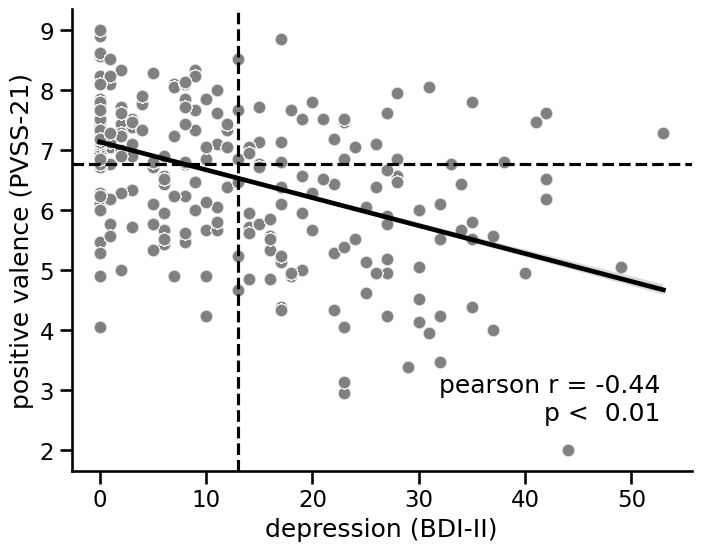

In [30]:
# Figure 1a
plt.figure(figsize=(8, 6))

# Scatterplot with regression line
sns.scatterplot(data=ug_glm, x='bdi_total', y='pvss_total', color='grey', alpha=0.5)
sns.regplot(data=ug_glm, x='bdi_total', y='pvss_total', ci=95, scatter=False, color='black')

# Add cutoff lines
plt.axvline(x=13, color='black', linestyle='--')
plt.axhline(y=pvss_med, color='black', linestyle='--')

# Add labels and title
plt.xlabel('depression (BDI-II)')
plt.ylabel('positive valence (PVSS-21)')

# Remove unnecessary spines
sns.despine()

# pearson correlation coefficient and p-value
corr, p = stats.pearsonr(ug_glm['bdi_total'], ug_glm['pvss_total'])
print('r =',corr, 'p =', p)

# add stats text 
plt.text(0.95, 0.10, f'pearson r = {corr:.2f}\np <  0.01', ha='right', va='bottom', transform=plt.gca().transAxes)

# Save the figure
plt.savefig('./figure/fig1a_2.pdf', dpi=300, bbox_inches='tight')

C:\Users\fuq01\AppData\Local\Temp\ipykernel_28428\300525704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_group['group'] = sub_group['group'].astype(cat_order)
C:\Users\fuq01\AppData\Local\Temp\ipykernel_28428\300525704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_group.sort_values('group', inplace=True)
C:\Users\fuq01\AppData\Local\Temp\ipykernel_28428\300525704.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels([label_map[x.get_text()] for x in g.get_xticklabels()])


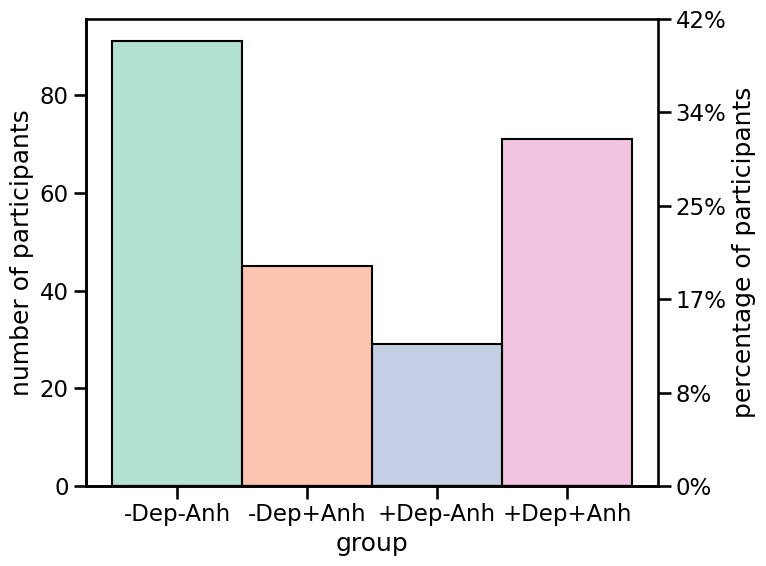

In [31]:
# Figure 1b
sub_group = ug_glm.drop_duplicates(subset=['participant'])
cat_order = CategoricalDtype(['Healthy', 'Anhedonia', 'Depression', 'Both'], ordered=True)
sub_group['group'] = sub_group['group'].astype(cat_order)
sub_group.sort_values('group', inplace=True)

plt.figure(figsize=(8, 6))

# Plot with percentage
g = sns.histplot(data=sub_group, x="group", stat='count', hue='group', palette='Set2', legend=False)
sns.despine(trim=False)

# Create a secondary y-axis for percentage
ax1 = g.axes  # Primary y-axis
ax2 = ax1.twinx()  # Secondary y-axis

# Match percentage scale for secondary axis
total_count = len(sub_group)
ax2.set_ylim(0, 100)  # Set percentage range
ax2.set_yticks(ax1.get_yticks())  # Match the ticks
ax2.set_yticklabels([f'{tick / total_count * 100:.0f}%' for tick in ax1.get_yticks()])  # Convert to percentage
ax2.set_ylabel('percentage of participants')

# Replace x-axis labels
label_map = {'Healthy': '-Dep-Anh', 'Anhedonia': '-Dep+Anh', 'Depression': '+Dep-Anh', 'Both': '+Dep+Anh'}
g.set_xticklabels([label_map[x.get_text()] for x in g.get_xticklabels()])

# Labels and title
ax1.set_ylabel('number of participants')

plt.tight_layout()

# Save the figure
plt.savefig('./figure/fig1b_2.pdf', dpi=300, bbox_inches='tight')

In [32]:
# Calculate counts and percentages
group_summary = sub_group.groupby(['group'])['participant'].count().reset_index()
group_summary.rename(columns={'participant': 'count'}, inplace=True)

# Add percentage column
total_count = group_summary['count'].sum()
group_summary['percentage'] = (group_summary['count'] / total_count) * 100

# Format percentage for better readability (optional)
group_summary['percentage'] = group_summary['percentage'].map('{:.2f}%'.format)

group_summary

,group,count,percentage
0,Healthy,91,38.56%
1,Anhedonia,45,19.07%
2,Depression,29,12.29%
3,Both,71,30.08%
